<a href="https://colab.research.google.com/github/plaban1981/Huggingface_transformers_course/blob/main/HuggingFace_Crash_Course_Sentiment_Analysis%2C_Model_Hub%2C_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 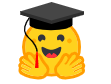HugggingFace Crash Course - Sentiment Analysis, Model Hub, Fine Tuning

In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 13.7 MB/s 
     |████████████████████████████████| 895 kB 67.9 MB/s 
     |████████████████████████████████| 636 kB 71.8 MB/s 
     |████████████████████████████████| 3.3 MB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline
import torch
import torch.nn.functional as F

## Using default pipeline with the default model

In [ ]:
classifier = pipeline('sentiment-analysis')

## Inferencing the results

In [ ]:
result = classifier("I am very happy to recieve my promotion")
print(result)

[{'label': 'POSITIVE', 'score': 0.9998338222503662}]


## Classifying multiple sentences

In [ ]:
sentences = ["I am very 🤗  to recieve my promotion","I hate to saye goodbye"]
results = classifier(sentences)
for result in results:
  print(result)

{'label': 'POSITIVE', 'score': 0.99614018201828}
{'label': 'NEGATIVE', 'score': 0.9710088968276978}


## How to use a concrete model and a tokenizer

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline('sentiment-analysis',model=model_name)
results = classifier(sentences)
for result in results:
  print(result)

{'label': 'POSITIVE', 'score': 0.9998338222503662}
{'label': 'NEGATIVE', 'score': 0.9710088968276978}


## Base Models from Huggingface using checkpoints - Model and Tokenizor

In [ ]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
results = classifier(sentences)
for result in results:
  print(result)

{'label': 'POSITIVE', 'score': 0.9998338222503662}
{'label': 'NEGATIVE', 'score': 0.9710088968276978}


## Tokenize function

In [ ]:
tokens = tokenizer.tokenize(sentences)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = tokenizer(sentences)

In [ ]:
print(f'tokens : {tokens}')
print(f'token_ids : {token_ids}')
print(f'input_ids : {input_ids}')

tokens : ['i', 'am', 'very', '[UNK]', 'to', 'rec', '##ie', '##ve', 'my', 'promotion', 'i', 'hate', 'to', 'say', '##e', 'goodbye']
token_ids : [1045, 2572, 2200, 100, 2000, 28667, 2666, 3726, 2026, 4712, 1045, 5223, 2000, 2360, 2063, 9119]
input_ids : {'input_ids': [[101, 1045, 2572, 2200, 100, 2000, 28667, 2666, 3726, 2026, 4712, 102], [101, 1045, 5223, 2000, 2360, 2063, 9119, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}


## Creating training batch

In [22]:
X_train = sentences
batch = tokenizer(X_train,padding=True,truncation=True,max_length=412,return_tensors='pt')
print(batch)

{'input_ids': tensor([[  101,  1045,  2572,  2200,   100,  2000, 28667,  2666,  3726,  2026,
          4712,   102],
        [  101,  1045,  5223,  2000,  2360,  2063,  9119,   102,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}


## Inference the model output

In [25]:
with torch.no_grad(): 
  # used for inference(gradient tracking)
  outputs = model(**batch)  #  ** --> unpack the batch
  print(outputs)
  #prediction probabilities
  predictions = F.softmax(outputs.logits,dim=1)
  print(predictions)
  labels = torch.argmax(predictions,dim=1)
  print(labels)
  labels = [model.config.id2label[label_id] for label_id in labels.tolist()]
  print(labels)


SequenceClassifierOutput(loss=None, logits=tensor([[-2.7122,  2.8410],
        [ 1.8828, -1.6285]]), hidden_states=None, attentions=None)
tensor([[0.0039, 0.9961],
        [0.9710, 0.0290]])
tensor([1, 0])
['POSITIVE', 'NEGATIVE']


* here we see loss=None , so in order to compute loss we need the below code

In [26]:
with torch.no_grad(): 
  # used for inference(gradient tracking)
  outputs = model(**batch,labels=torch.tensor([1,0]))  #  ** --> unpack the batch
  print(outputs)
  #prediction probabilities
  predictions = F.softmax(outputs.logits,dim=1)
  print(predictions)
  labels = torch.argmax(predictions,dim=1)
  print(labels)
  labels = [model.config.id2label[label_id] for label_id in labels.tolist()]
  print(labels)

SequenceClassifierOutput(loss=tensor(0.0166), logits=tensor([[-2.7122,  2.8410],
        [ 1.8828, -1.6285]]), hidden_states=None, attentions=None)
tensor([[0.0039, 0.9961],
        [0.9710, 0.0290]])
tensor([1, 0])
['POSITIVE', 'NEGATIVE']


## Save the trained model

In [27]:
save_directory = "/content/"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

## Load the saved model

In [28]:
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model_ = AutoModelForSequenceClassification.from_pretrained(save_directory)

## Trying out other models

In [45]:
# Define the model repo
model_name = "oliverguhr/german-sentiment-bert" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_ = AutoModelForSequenceClassification.from_pretrained(model_name)
X_train_german = ["Mit keinem guten Ergebniss",
                  "Das ist gar nicht mal so gut",
                  "Total awesome!",
                  "nicht so schlecht wie erwartet",
                  "Der Test verlief positiv.",
                  "Sie fährt ein grünes Auto.",
                  "ich liebe Deutschland",
                  "Ich habe ein rotes Hemd"]

batch = tokenizer(X_train_german,padding=True,truncation=True,max_length=512,return_tensors='pt')
print(batch)
#batch = {k:v for k,v in batch.items() if k != 'token_type_ids'}
#print(batch)
with torch.no_grad(): 
  # used for inference(gradient tracking)
  outputs = model(**batch)  #  ** --> unpack the batch
  print(outputs)
  label_ids = torch.argmax(outputs.logits,dim=1)
  print(label_ids)
  labels = [model.config.id2label[label_id] for label_id in label_ids.tolist()]
  print(labels)

{'input_ids': tensor([[    3,   304,  8524,  5569,  2011, 26902,     4,     0,     0],
        [    3,   295,   127,  2523,   149,  2723,   181,  1522,     4],
        [    3, 19990,    18,  7117,  4741, 26982,     4,     0,     0],
        [    3,   149,   181,  6975,   246,  6303,     4,     0,     0],
        [    3,   233,  4496, 14332,  8453, 26914,     4,     0,     0],
        [    3,   371,  9755,    39, 19044, 26902,  3512, 26914,     4],
        [    3,  1169, 16619,   832,     4,     0,     0,     0,     0],
        [    3,  1671,   555,    39, 14737, 26902, 11529, 26904,     4]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1,

TypeError: ignored

## Fine Tuning  Custom models

* Prepare dataset
* Load pretrained tokenizer, call it with dataset
* Build Pytorch datasets with encodings
* Load pretrained Model
* Load Trainer and train it OR
* use native Pytorch training Pipeline

In [4]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

In [5]:
model_name  = 'distilbert-base-uncased'

## Download Data

In [6]:
! wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar -xf aclImdb_v1.tar.gz

--2021-08-01 17:03:06--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.2MB/s    in 5.7s    

2021-08-01 17:03:12 (14.0 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



## This data is organized into pos and neg folders with one text file per example

In [7]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('/content/aclImdb/train')
test_texts, test_labels = read_imdb_split('/content/aclImdb/test')

## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,random_state=42)

## Tokenization

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

* Now we can simply pass our texts to the tokenizer. We’ll pass truncation=True and padding=True, which will ensure that all of our sequences are padded to the same length and are truncated to be no longer model’s maximum input length

* This will allow us to feed batches of sequences into the model at the same time.

In [10]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

* Turn our labels and encodings into a Dataset object. 
* In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing __len__ and __getitem__.

In [12]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

## Fine-tuning with Trainer

In [14]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [15]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Step,Training Loss
10,0.690400
20,0.691500
30,0.689900
40,0.688500
50,0.687800
60,0.685700
70,0.679800
80,0.654500
90,0.626200
100,0.550500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=3750, training_loss=0.18151747852414846, metrics={'train_runtime': 1656.3465, 'train_samples_per_second': 36.224, 'train_steps_per_second': 2.264, 'total_flos': 7948043919360000.0, 'train_loss': 0.18151747852414846, 'epoch': 3.0})

## Make predictions on TEST DATA

In [16]:
trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 25000
  Batch size = 64


PredictionOutput(predictions=array([[-3.668627  ,  2.8004818 ],
       [-3.9709244 ,  3.0006945 ],
       [-3.948936  ,  2.9792604 ],
       ...,
       [ 3.6315918 , -3.1083484 ],
       [ 0.91505814, -0.764803  ],
       [ 3.5193815 , -3.0515766 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.30835095047950745, 'test_runtime': 211.3681, 'test_samples_per_second': 118.277, 'test_steps_per_second': 1.85})

In [17]:
preds = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 25000
  Batch size = 64


In [21]:
predictions = preds[1].tolist()

In [28]:
test_texts[100]

"I have seen this movie twice now on cable. The first time I saw it, it caught me by suprise. The skaters I was seeing were the guys we followed in the pages of Skateboarder magazine back in the late 70's. These were the guys we copied and tried to become while skating. I am glad that a film was finally made that gives an accurate account of how it all came to be. I am almost 40 years old now and I guess a pretty uptight kind of guy with all of life's problems, however; this film did a great job of taking me back. Back to the vacant pools, the backyard halfpipes and the road trips to Cherry Hill NJ. I suspect that in order to really understand this movie and appreciate it, you had to live it. Otherwise, it probably won't have the impact on you as it did me. But for those of you (and you know who you are), who did live it, you know exactly what I am talking about! In any event, I don't care who you are, if you get a chance to see this movie...do it! I give thanks to the Z-Boys of Dogtow

In [29]:
predictions[100]

1

In [26]:
train_labels[0]

0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


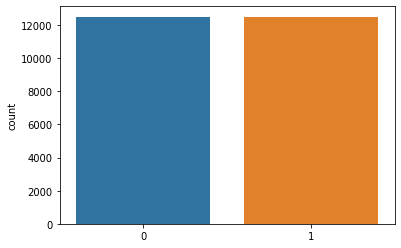

In [27]:
import seaborn as sns
sns.countplot(predictions)